<a href="https://colab.research.google.com/github/komosam/LSTM-for-Predictions/blob/master/LSTM_airline_passengers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [3]:
train_data = pd.read_csv('AirPassengers.csv',index_col=0,parse_dates=True)
train_data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [0]:
### Data Visualization

In [0]:
train_data_col = train_data['#Passengers']

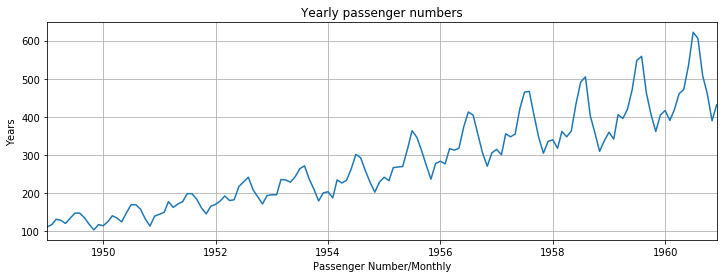

In [6]:
plt.figure(figsize=(12,4))
plt.title('Yearly passenger numbers')
plt.xlabel('Passenger Number/Monthly')
plt.ylabel('Years')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(train_data_col)


In [0]:
### Preprocessing

In [0]:
## Train Test Split

test_size = 15
train_set = train_data_col[:-test_size]
test_set = train_data_col[-test_size:]

In [9]:
len(train_set),len(test_set)

(129, 15)

In [0]:
## Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(-1,1))

In [0]:
train_set_array = np.array(train_set)
train_norm = sc.fit_transform(train_set_array.reshape(-1,1))


train_norm = torch.FloatTensor(train_norm).view(-1).to(device)

In [0]:
### Shape to get the LSTM Input

def inputs_data(seq,window_size):
  L = len(seq)
  out = []
  
  for i in range(window_size,L):
    window = seq[i-window_size:i]
    label  = seq[i]
    out.append((window,label))
    
  return out

In [0]:
window_size= 12

training_data = inputs_data(train_norm,window_size)

In [14]:
training_data[0]

(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
         -0.8593, -0.9341, -1.0000, -0.9385], device='cuda:0'),
 tensor(-0.9516, device='cuda:0'))

In [15]:
training_data[1]

(tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
         -0.9341, -1.0000, -0.9385, -0.9516], device='cuda:0'),
 tensor(-0.9033, device='cuda:0'))

In [0]:
### Modeling

In [0]:
class LSTM(nn.Module):
  def __init__(self,input_size=1,hidden_size=90,output_size=1):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size,hidden_size)
    self.linear = nn.Linear(hidden_size,output_size)
    self.hidden = (torch.zeros(1,1,self.hidden_size),torch.zeros(1,1,self.hidden_size))
  
  def forward(self,seq):
    lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1),self.hidden)
    pred = self.linear(lstm_out.view(len(seq),-1))
    return pred[-1]
  

In [18]:
torch.manual_seed(101)
model = LSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()
model

LSTM(
  (lstm): LSTM(1, 90)
  (linear): Linear(in_features=90, out_features=1, bias=True)
)

In [19]:
## Training 

epochs = 100

start_time = time.time()
acc_loss = []

for epoch in range(epochs):
  for seq, y_train in training_data:
    optimizer.zero_grad()
    model.hidden = (torch.zeros(1,1,model.hidden_size).to(device),
                   torch.zeros(1,1,model.hidden_size).to(device))
    y_pred = model(seq)
    
    loss = criterion(y_pred,y_train)
    loss.backward()
    optimizer.step()
    
  acc_loss.append(loss.item())
  print(f"Epoch {epoch} Loss {loss.item()}")
  
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss 0.32330065965652466
Epoch 1 Loss 0.3433464467525482
Epoch 2 Loss 0.29302793741226196
Epoch 3 Loss 0.22460812330245972
Epoch 4 Loss 0.15778601169586182
Epoch 5 Loss 0.10278163105249405
Epoch 6 Loss 0.06769636273384094
Epoch 7 Loss 0.05164541304111481
Epoch 8 Loss 0.04441177472472191
Epoch 9 Loss 0.03978915512561798
Epoch 10 Loss 0.0364176444709301
Epoch 11 Loss 0.03390773758292198
Epoch 12 Loss 0.0320681668817997
Epoch 13 Loss 0.030739692971110344
Epoch 14 Loss 0.029787180945277214
Epoch 15 Loss 0.02910553850233555
Epoch 16 Loss 0.02861783094704151
Epoch 17 Loss 0.02826925367116928
Epoch 18 Loss 0.028021004050970078
Epoch 19 Loss 0.02784586511552334
Epoch 20 Loss 0.027724603191018105
Epoch 21 Loss 0.02764364704489708
Epoch 22 Loss 0.027593474835157394
Epoch 23 Loss 0.027567392215132713
Epoch 24 Loss 0.02756069228053093
Epoch 25 Loss 0.02756994590163231
Epoch 26 Loss 0.027592623606324196
Epoch 27 Loss 0.027626633644104004
Epoch 28 Loss 0.027670351788401604
Epoch 29 Loss 0.02

In [0]:
## Test

future = 15


preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
  seq = torch.FloatTensor(preds[-window_size:]).to(device)
  with torch.no_grad():
    model.hidden = (torch.zeros(1,1,model.hidden_size).to(device),
                   torch.zeros(1,1,model.hidden_size).to(device))
    
    preds.append(model(seq).item())



In [0]:
### inverse transform data

In [0]:
#dates = np.arange('2019-05-17','2019-06-29',dtype='datetime64[M]').astype('datetime64[D]')
predictions = sc.inverse_transform(np.array(preds[-future:]).reshape(-1, 1))

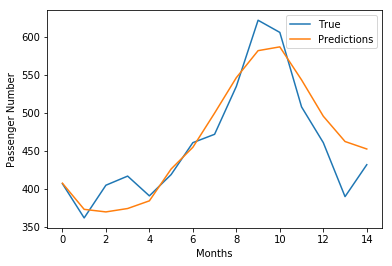

In [23]:
plt.plot(test_set.values,label='True')
plt.plot(predictions,label='Predictions')
plt.xlabel("Months")
plt.ylabel("Passenger Number");
plt.legend()

In [0]:
### LOss

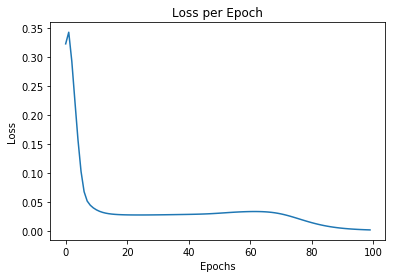

In [25]:
plt.plot(acc_loss)
plt.title('Loss per Epoch')
plt.xlabel("Epochs")
plt.ylabel("Loss");